# ChartQA dataset

In [4]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [5]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [6]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=["train[:2%]", "val[:2%]", "test[:2%]"], cache_dir="/data/AISeed/huggingface")

In [7]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

# Test the model

In [1]:
from transformers import AutoProcessor, Llama4ForConditionalGeneration, BitsAndBytesConfig
import torch

model_id = "meta-llama/Llama-4-Scout-17B-16E-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    attn_implementation="eager",
    bnb_4bit_use_double_quant=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=torch.bfloat16
)


processor = AutoProcessor.from_pretrained(model_id)
model = Llama4ForConditionalGeneration.from_pretrained(
    model_id,
    # attn_implementation="flex_attention",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    cache_dir="/data/AISeed/huggingface"
)

Loading checkpoint shards:   0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
from PIL import Image

def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs

In [2]:
def generate_text_from_sample(sample, model, processor, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample, tokenize=False, add_generation_prompt=True  # Use the sample without the system message
    )
    print(f"Text input: {text_input}")
    # Process the visual input from the sample
    image_inputs = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [ ]:
def generate_text_from_sample(sample, model, processor, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    model_inputs = processor.apply_chat_template(
        sample, 
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        add_generation_prompt=True  # Use the sample without the system message
    )
 
    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=309x456>},
   {'type': 'text', 'text': 'What is the data in Jul 2015 ( all two data)?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '[63, 26]'}]}]

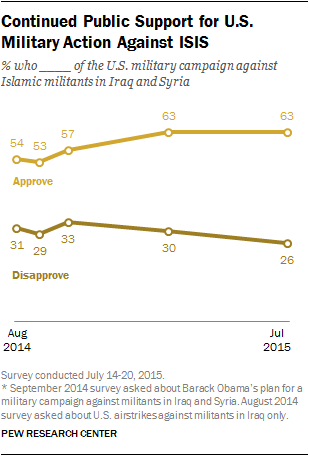

In [11]:
sample = train_dataset[20]
display(sample)
display(sample[1]["content"][0]["image"])

In [16]:
output = generate_text_from_sample(sample[:2], model, processor)
output

/home/ubuntu/miniforge3/envs/pt24_py311/lib/python3.11/site-packages/transformers/generation/utils.py:2347: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


'To find the data in Jul 2015, we need to look at the chart image and locate the point on the graph corresponding to Jul 2015. The chart shows two lines representing "Approve" and "Disapprove". \n\nIn Jul 2015, the "Approve" data is 63 and the "Disapprove" data is 26.\n\nFINAL ANSWER: 63, 26.'

# Instruction tunning

In [3]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=4,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 3,911,680 || all params: 108,645,705,216 || trainable%: 0.0036


In [9]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="Llama-4-Scout-17B-chartQA",  # Directory to save the model
    num_train_epochs=1,  # Number of training epochs
    per_device_train_batch_size=1,  # Batch size for training
    per_device_eval_batch_size=1,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="constant",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=5,  # Steps interval for logging
    eval_steps=5,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=5,  # Steps interval for saving
    save_total_limit=3,  # Maximum number of saved checkpoints
    metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    greater_is_better=False,  # Whether higher metric values are better
    # load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    # tf32=True,  # Use TensorFloat-32 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="tensorboard",  # Reporting tool for tracking metrics
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    # max_seq_length=1024  # Maximum sequence length for input
)

In [10]:
def collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image_inputs = process_vision_info(example)
        text = processor.apply_chat_template(
            example, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch = processor(
        text=texts, 
        images=images, 
        return_tensors="pt",
        padding=True)

    # The labels are the input_ids, and we mask the padding tokens and image tokens in the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_tokens = [
            processor.tokenizer.convert_tokens_to_ids("<image>")
        ]

    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels
  
    batch["labels"] = labels
  
    return batch

In [11]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.00 GiB. GPU 0 has a total capacity of 79.15 GiB of which 4.40 GiB is free. Including non-PyTorch memory, this process has 74.74 GiB memory in use. Of the allocated memory 65.10 GiB is allocated by PyTorch, and 9.16 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.train()